بسم الله الرحمن الرحيم

# **Pneumonia Classification Model Training -تدريب نموذج تصنيف الإلتهاب الرئوية**

***Author: Ziad ElShazly -زياد الشاذلي***

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Environment and Data Setup

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import shutil

def setup_environment():
    print("Setting up Kaggle API credentials...")
    kaggle_json_path_content = '/content/kaggle.json'
    kaggle_json_path_kaggle = '/root/.config/kaggle/kaggle.json'

    if not os.path.exists(kaggle_json_path_content):
        print("""
        Please upload your kaggle.json file to Google Colab.
        To do this:
        1. Go to your Kaggle account -> 'Account' tab.
        2. Click 'Create New API Token' to download kaggle.json.
        3. In Colab, go to the left sidebar -> 'Files' -> 'Upload'.
        4. Upload your kaggle.json file.
        5. Run this cell again.
        """)
    else:
        print("Kaggle API key found in /content/.")
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(kaggle_json_path_kaggle), exist_ok=True)
        # Move the kaggle.json file to the expected location
        shutil.move(kaggle_json_path_content, kaggle_json_path_kaggle)
        print(f"Moved kaggle.json to {kaggle_json_path_kaggle}")
        os.environ['KAGGLE_CONFIG_DIR'] = '/root/.config/kaggle' # Set environment variable

def download_and_unzip_dataset(dataset_name):

    print(f"Downloading dataset: {dataset_name}...")
    try:
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(dataset_name, path='.', unzip=True)
        print("Dataset downloaded and unzipped successfully.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please ensure your kaggle.json is correctly uploaded and the dataset name is valid.")

DATASET_NAME = 'paultimothymooney/chest-xray-pneumonia'
# Define the base directory where the dataset is unzipped
BASE_DATA_DIR = 'chest_xray'
# Define specific directories for train, test, and validation data
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'val')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

setup_environment()
download_and_unzip_dataset(DATASET_NAME)

Setting up Kaggle API credentials...
Kaggle API key found in /content/.
Moved kaggle.json to /root/.config/kaggle/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Dataset downloaded and unzipped successfully.


#  2. Data Preprocessing and Splitting

In [4]:
def create_dataframe(data_dir):
    """
    Creates a pandas DataFrame with image filepaths, labels, and patient IDs
    from the specified data directory. Includes checks for file existence.
    """
    filepaths = []
    labels = []
    patient_ids = []

    # Define the labels (subdirectories) to look for
    classes = ['NORMAL', 'PNEUMONIA']

    print(f"Creating DataFrame from directory: {data_dir}")

    for label in classes:
        label_path = os.path.join(data_dir, label)
        if not os.path.exists(label_path):
            print(f"Warning: Directory not found: {label_path}. Skipping.")
            continue

        # Look for image files within the label directory
        path = os.path.join(label_path, '*.jp*g') # Corrected to match file extensions
        files = glob(path)

        if not files:
            print(f"Warning: No image files found in {label_path}. Skipping label {label}.")
            continue

        for f in files:
            filepaths.append(f)
            labels.append(label)
            # Extract patient ID for patient-level splitting
            filename = os.path.basename(f)
            # Patient ID is the first part of the filename, e.g., 'person1_bacteria_1.jpeg' -> 'person1'
            patient_id = filename.split('_')[0]
            patient_ids.append(patient_id)

    if not filepaths:
        print(f"Error: No image files found in the specified directory tree: {data_dir}. DataFrame will be empty.")
        return pd.DataFrame({'filepath': [], 'label': [], 'patient_id': []})


    df = pd.DataFrame({'filepath': filepaths, 'label': labels, 'patient_id': patient_ids})
    df['label'] = df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
    # No need to shuffle here, as flow_from_dataframe handles shuffling
    # df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"DataFrame created with {len(df)} images from {data_dir}.")
    return df

def patient_level_split(df):
    """
    Performs a patient-level split to ensure no patient is in both training and validation sets.
    Handles empty DataFrame input.
    """
    if df.empty:
        print("Input DataFrame is empty. Cannot perform patient-level split.")
        return pd.DataFrame(), pd.DataFrame()

    unique_patients = df['patient_id'].unique()
    train_patients, val_patients = [], []

    # Use GroupKFold to ensure a robust split
    gkf = GroupKFold(n_splits=5)
    train_df, val_df = pd.DataFrame(), pd.DataFrame() # Initialize empty dataframes

    for train_idx, val_idx in gkf.split(df, groups=df['patient_id']):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        train_patients = train_df['patient_id'].unique()
        val_patients = val_df['patient_id'].unique()

        # Check for patient overlap
        if len(set(train_patients) & set(val_patients)) == 0:
            print("Patient-level split successful. No patient overlap between training and validation sets.")
            break
        else:
            print("Patient overlap detected, trying a new split...")

    if len(set(train_patients) & set(val_patients)) > 0:
      print("Warning: Could not find a perfect patient-level split after 5 attempts. Some patient overlap may exist.")

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    return train_df, val_df

In [5]:
# Load and split the data
print("Creating DataFrames for train and validation sets...")
train_df = create_dataframe(TRAIN_DIR)
val_df = create_dataframe(VAL_DIR)
# Create a separate dataframe for the test set
print("Creating DataFrame for the test set...")
test_df = create_dataframe(TEST_DIR)

Creating DataFrames for train and validation sets...
Creating DataFrame from directory: chest_xray/train
DataFrame created with 5216 images from chest_xray/train.
Creating DataFrame from directory: chest_xray/val
DataFrame created with 16 images from chest_xray/val.
Creating DataFrame for the test set...
Creating DataFrame from directory: chest_xray/test
DataFrame created with 624 images from chest_xray/test.


In [6]:
train_df.head()

,filepath,label,patient_id
0,chest_xray/train/NORMAL/NORMAL2-IM-1345-0001-0...,0,NORMAL2-IM-1345-0001-0002.jpeg
1,chest_xray/train/NORMAL/NORMAL2-IM-1049-0001.jpeg,0,NORMAL2-IM-1049-0001.jpeg
2,chest_xray/train/NORMAL/NORMAL2-IM-0555-0001.jpeg,0,NORMAL2-IM-0555-0001.jpeg
3,chest_xray/train/NORMAL/NORMAL2-IM-0665-0001.jpeg,0,NORMAL2-IM-0665-0001.jpeg
4,chest_xray/train/NORMAL/IM-0224-0001.jpeg,0,IM-0224-0001.jpeg


In [7]:
val_df.head()

,filepath,label,patient_id
0,chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg,0,NORMAL2-IM-1438-0001.jpeg
1,chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg,0,NORMAL2-IM-1437-0001.jpeg
2,chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg,0,NORMAL2-IM-1440-0001.jpeg
3,chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg,0,NORMAL2-IM-1436-0001.jpeg
4,chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg,0,NORMAL2-IM-1431-0001.jpeg


In [8]:
test_df.head

<bound method NDFrame.head of                                               filepath  label  \
0     chest_xray/test/NORMAL/NORMAL2-IM-0252-0001.jpeg      0   
1     chest_xray/test/NORMAL/NORMAL2-IM-0135-0001.jpeg      0   
2     chest_xray/test/NORMAL/NORMAL2-IM-0217-0001.jpeg      0   
3     chest_xray/test/NORMAL/NORMAL2-IM-0131-0001.jpeg      0   
4     chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg      0   
..                                                 ...    ...   
619  chest_xray/test/PNEUMONIA/person111_bacteria_5...      1   
620  chest_xray/test/PNEUMONIA/person139_bacteria_6...      1   
621  chest_xray/test/PNEUMONIA/person130_bacteria_6...      1   
622  chest_xray/test/PNEUMONIA/person91_bacteria_44...      1   
623  chest_xray/test/PNEUMONIA/person109_bacteria_5...      1   

                    patient_id  
0    NORMAL2-IM-0252-0001.jpeg  
1    NORMAL2-IM-0135-0001.jpeg  
2    NORMAL2-IM-0217-0001.jpeg  
3    NORMAL2-IM-0131-0001.jpeg  
4    NORMAL2-IM-0145-0001.jpeg  
..                         ...  
619                  person111  
620                  person139  
621                  person130  
622                   person91  
623                  person109  

[624 rows x 3 columns]>

In [9]:
# Data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 5216 validated image filenames.
Found 16 validated image filenames.


# 3. Model Definition and Training

In [10]:
def build_model(input_shape, num_classes):
    """
    Builds a DenseNet-121 model using pre-trained weights,
    adds custom classification layers, and compiles the model.
    """
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
# Build the model
print("Building the DenseNet-121 model...")
model = build_model(input_shape=(224, 224, 3), num_classes=1)

Building the DenseNet-121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


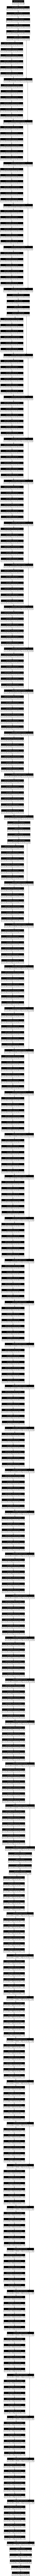

In [12]:
# Plot the model architecture Add dpi and expand_nested for clearer and more detailed diagrams
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=96, expand_nested=True)

In [13]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <ZeroPadding2D name=zero_padding2d, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <BatchNormalization name=conv1_bn, built=True>,
 <Activation name=conv1_relu, built=True>,
 <ZeroPadding2D name=zero_padding2d_1, built=True>,
 <MaxPooling2D name=pool1, built=True>,
 <BatchNormalization name=conv2_block1_0_bn, built=True>,
 <Activation name=conv2_block1_0_relu, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>,
 <BatchNormalization name=conv2_block1_1_bn, built=True>,
 <Activation name=conv2_block1_1_relu, built=True>,
 <Conv2D name=conv2_block1_2_conv, built=True>,
 <Concatenate name=conv2_block1_concat, built=True>,
 <BatchNormalization name=conv2_block2_0_bn, built=True>,
 <Activation name=conv2_block2_0_relu, built=True>,
 <Conv2D name=conv2_block2_1_conv, built=True>,
 <BatchNormalization name=conv2_block2_1_bn, built=True>,
 <Activation name=conv2_block2_1_relu, built=True>,
 <Conv2D name=conv2_block2_2_conv, built=True>

In [14]:
for layer in model.layers:
        trainable_status = "TRAINABLE" if layer.trainable else "FROZEN"
        print(f"{layer.name:15} - {trainable_status:15} - {layer.__class__.__name__}")


input_layer     - FROZEN          - InputLayer
zero_padding2d  - FROZEN          - ZeroPadding2D
conv1_conv      - FROZEN          - Conv2D
conv1_bn        - FROZEN          - BatchNormalization
conv1_relu      - FROZEN          - Activation
zero_padding2d_1 - FROZEN          - ZeroPadding2D
pool1           - FROZEN          - MaxPooling2D
conv2_block1_0_bn - FROZEN          - BatchNormalization
conv2_block1_0_relu - FROZEN          - Activation
conv2_block1_1_conv - FROZEN          - Conv2D
conv2_block1_1_bn - FROZEN          - BatchNormalization
conv2_block1_1_relu - FROZEN          - Activation
conv2_block1_2_conv - FROZEN          - Conv2D
conv2_block1_concat - FROZEN          - Concatenate
conv2_block2_0_bn - FROZEN          - BatchNormalization
conv2_block2_0_relu - FROZEN          - Activation
conv2_block2_1_conv - FROZEN          - Conv2D
conv2_block2_1_bn - FROZEN          - BatchNormalization
conv2_block2_1_relu - FROZEN          - Activation
conv2_block2_2_conv - FROZEN     

In [15]:
# Set up callbacks

# ModelCheckpoint saves the model with the highest validation accuracy
checkpoint_cb = ModelCheckpoint(
    'pneumonia_detection_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training when validation accuracy stops improving
# restore_best_weights=True ensures the model uses weights from the epoch with the best validation accuracy
early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau reduces the learning rate when validation loss plateaus
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [16]:
# Train the model
print("Starting model training...")
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8130 - loss: 0.4342
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to pneumonia_detection_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1052s 6s/step - accuracy: 0.8134 - loss: 0.4332 - val_accuracy: 0.8125 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9353 - loss: 0.1729
Epoch 2: val_accuracy improved from 0.81250 to 0.87500, saving model to pneumonia_detection_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1015s 6s/step - accuracy: 0.9353 - loss: 0.1728 - val_accuracy: 0.8750 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9374 - loss: 0.1535
Epoch 3: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 1020s 6s/step - accuracy: 0.9374 - loss: 0.1535 - val_accuracy: 0.8125 - val_loss: 0.3990 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9274 - loss: 0.1648
Epoch 4: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 1023s 6s/step - accuracy: 0.9275 - loss: 0.1647 - val_accuracy: 0.8750 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9370 - loss: 0.1590
Epoch 5: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 1001s 6s/step - accuracy: 0.9370 - loss: 0.1590 - val_accuracy: 0.8125 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 6/10
163/163 ━

# 3.1 Model Summary

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,431,493 (28.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 262,660 (1.00 MB)

# 4. Model Evaluation


In [21]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False  # Important: Do not shuffle test data for correct evaluation
)

# Evaluate the model on the test set
print("Evaluating model performance on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 624 validated image filenames.
Evaluating model performance on the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.9013 - loss: 0.2475
Test Loss: 0.3464
Test Accuracy: 0.8574


# 5. Saving the Final Model

In [22]:
def save_model(model, filename):
    """
    Saves the final trained model.
    """
    print(f"Saving the final model to {filename}...")
    model.save(filename)
    print("Model saved successfully.")

# Save the final model in the recommended Keras format
save_model(model, 'pneumonia_classifier_final_model.keras')

print("\n\nScript execution complete. The trained model has been saved.")

Saving the final model to pneumonia_classifier_final_model.keras...
Model saved successfully.


Script execution complete. The trained model has been saved.
